# PV Simulation 

## tests

In [ ]:
# tmy import & save
import pvlib
import pandas as pd 
import constants as c 

pv_gis_data, input_data, meta, additional_info = pvlib.iotools.get_pvgis_tmy(
    latitude=c.BREITENGRAD, 
    longitude=c.LAENGENGRAD, 
    startyear=c.STARTJAHR, 
    endyear=c.ENDJAHR, 
    outputformat='json', 
    usehorizon=True, 
    userhorizon=None, 
    url='https://re.jrc.ec.europa.eu/api/v5_2/', 
    map_variables=True, 
    timeout=30
)

# print(pv_gis_data)
# print(input_data)
# print(meta)
# print(additional_info)

# pv_gis_data['poa_diffuse'] = pv_gis_data['poa_sky_diffuse']+ pv_gis_data['poa_ground_diffuse']
# pv_gis_data['poa_global'] = pv_gis_data['poa_diffuse'] + pv_gis_data['poa_direct']

# pv_gis_data.index = pd.to_datetime(pv_gis_data.index, format="%Y%m%d:H&M") print(pv_gis_data)
pv_gis_data.to_csv("pv_gis_data.csv")

In [ ]:
# formatieren der tmy Daten 
import pandas as pd 

tmy = pd.read_csv("pv_gis_data.csv", 
                 usecols=["time(UTC)", "temp_air", "ghi", "dni", "dhi", "IR(h)", "wind_speed", "wind_direction"],
                  index_col= 0, 
                 )
tmy.index = pd.date_range(
    start= "2021-01-01 00:00", 
        end= "2021-12-31 23:00", 
    freq= "h" 
)


print(tmy)
tmy.plot(figsize = (9,16)) 

In [ ]:
#PVGIS import spezifisches Jahr 
import pvlib
import pandas as pd 
import constants as c 


pv_gis_data, input, meta = pvlib.iotools.get_pvgis_hourly(
    latitude = c.BREITENGRAD, 
    longitude = c.LAENGENGRAD, 
    start=2020, end=2020, 
    raddatabase="PVGIS-SARAH2", components=True, 
    surface_tilt=45, surface_azimuth=0, 
    outputformat='json', usehorizon=True, 
    userhorizon=None, 
    pvcalculation=False, # deaktiviert die PV Kalkulation von PV lib 
    peakpower=None, pvtechchoice='crystSi', 
    mountingplace='free', loss=0, trackingtype=0, 
    optimal_surface_tilt=False, optimalangles=False, 
    url='https://re.jrc.ec.europa.eu/api/v5_2/', 
    map_variables=True, timeout=30)



pv_gis_data['poa_diffuse'] = pv_gis_data['poa_sky_diffuse']+ pv_gis_data['poa_ground_diffuse']
pv_gis_data['poa_global'] = pv_gis_data['poa_diffuse'] + pv_gis_data['poa_direct']

# pv_gis_data.index = pd.to_datetime(pv_gis_data.index, format="%Y%m%d:H&M") print(pv_gis_data)
# pv_gis_data.to_csv("pv_gis_data.csv")

print(pv_gis_data)

In [ ]:
#test mit export Datein 

import tkinter as tk
from tkinter import ttk
from threading import Thread
import constants as c
from functions import calculation_pv
from plotting import plot_results

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'Breitengrad': c.BREITENGRAD,
    'Laengengrad': c.LAENGENGRAD,
    'Hoehe': c.HOEHE,
    'tilt': c.ANSTELLWINKEL,
    'azimuth': c.AZIMUTH,
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59',
    'schrittweite': '1',  # Standardmäßig 1 Minute Schrittweite
    'pdc0': '250',
    'gamma_pdc': '-0.004',
    'a_ref': '1.5',
    'Il_ref': '6',
    'I0_ref': '0.001',
    'Rs_ref': '0.5',
    'Rsh_ref': '2000',
    'Adjust': '8.2',
    'Technology': 'monocrystalline',
    'pdc0_inv': '240',
    'eta_inv_nom': '0.96',
    'eta_inv_ref': '0.9637'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.tabs = []
        self.entries = []

        self.create_tabs()
        self.create_calculation_button()

    def create_tabs(self):
        tab_control = ttk.Notebook(self.root)
        
        # Tab für allgemeine Einstellungen
        tab1 = ttk.Frame(tab_control)
        tab_control.add(tab1, text='Allgemein')
        self.create_input_frame(tab1, ['Breitengrad', 'Laengengrad', 'Hoehe', 'tilt', 'azimuth', 'startzeit', 'endzeit', 'schrittweite'])
        self.tabs.append(tab1)

        # Tab für Modulparameter
        tab2 = ttk.Frame(tab_control)
        tab_control.add(tab2, text='Modulparameter')
        self.create_input_frame(tab2, ['pdc0', 'gamma_pdc', 'a_ref', 'Il_ref', 'I0_ref', 'Rs_ref', 'Rsh_ref', 'Adjust', 'Technology'])
        self.tabs.append(tab2)

        # Tab für Wechselrichterparameter
        tab3 = ttk.Frame(tab_control)
        tab_control.add(tab3, text='Wechselrichterparameter')
        self.create_input_frame(tab3, ['pdc0_inv', 'eta_inv_nom', 'eta_inv_ref'])
        self.tabs.append(tab3)

        tab_control.pack(expand=1, fill="both")

    def create_input_frame(self, frame, keys):
        frame = tk.Frame(frame, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        entries = {}
        row = 0
        for key in keys:
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, DEFAULT_VALUES[key])
            entries[key] = entry
            row += 1

        self.entries.append(entries)

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_thread)
        thread.start()

    def berechnung_thread(self):
        erzeugte_energie, stromerzeugung, berechnungszeit = calculation_pv(self.entries)
        if erzeugte_energie is not None and stromerzeugung is not None:
            plot_results(self.root, erzeugte_energie, stromerzeugung, berechnungszeit, self.entries)

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


### nur in python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location 
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

# Standort definieren (Beispiel: Freiburg, Deutschland)
standort = Location(
    latitude=47.9936,  # Breitengrad
    longitude=7.8522,  # Längengrad
    altitude=278,      # Höhe über dem Meeresspiegel in Metern
    tz='Europe/Berlin' # Zeitzone
)

# Zeitraum für die Berechnung festlegen
startzeit = pd.Timestamp('2024-06-01 00:00:00', tz='Europe/Berlin')
endzeit = pd.Timestamp('2024-06-05 23:59:59', tz='Europe/Berlin')
zeit_index = pd.date_range(start=startzeit, end=endzeit, freq='1min', tz='Europe/Berlin')

# Solare Einstrahlung berechnen (minütliche Auflösung)
solare_einstrahlung = standort.get_clearsky(zeit_index)

# Wetterdaten generieren (fiktive Daten)
# In einer realen Anwendung sollten diese Daten aus einer Wetterdatenquelle stammen
temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
windgeschwindigkeit = pd.Series(2, index=zeit_index)

# Berechnung von dni und dhi basierend auf ghi
dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

wetterdaten = pd.DataFrame({
    'temp_air': temperaturen,
    'wind_speed': windgeschwindigkeit,
    'ghi': solare_einstrahlung['ghi'],
    'dni': dni,
    'dhi': dhi
}, index=zeit_index)

# Beispiel: Parameter eines Solarmoduls (fiktive Daten)
modul_parameter = {
    'pdc0': 250,  # Nennleistung (W)
    'gamma_pdc': -0.004,  # Leistungskoeffizient (%/°C)
    'a_ref': 1.5,  # Diode-Parameter
    'Il_ref': 6,   # Leerlaufstrom (A)
    'I0_ref': 0.001,  # Sättigungsstrom (A)
    'Rs_ref': 0.5,  # Serienwiderstand (Ohm)
    'Rsh_ref': 2000,  # Parallelwiderstand (Ohm)
    'Adjust': 8.2,  # Anpassungsfaktor
    'Technology': 'monocrystalline'  # Technologie des Moduls
}

# Beispiel: Parameter eines Wechselrichters (fiktive Daten)
wechselrichter_parameter = {
    'pdc0': 800,  # Nennleistung des Wechselrichters (W)
    'eta_inv_nom': 0.96,  # Wirkungsgrad des Wechselrichters (%)
    'eta_inv_ref': 0.9637  # Referenz-Wirkungsgrad des Wechselrichters (%)
}

# Parameter für das Temperaturmodell
temp_model_params = {
    'u_c': 29.0,  # Verlustfaktor für freistehende Montage (W/m²K)
    'u_v': 0.0   # Windverlustfaktor (W/m²K)/(m/s)
}

# Montagesystem definieren (Beispiel: feste Montierung)
mount = FixedMount(surface_tilt=30, surface_azimuth=180)  # Neigungswinkel: 30°, Azimut: 180° (Süden)

# Erstellung des Arrays mit Temperaturmodell und Montagesystem
array = Array(
    mount=mount, 
    module_parameters=modul_parameter, 
    temperature_model_parameters=temp_model_params, 
    modules_per_string=2)

# Erstellung des PV-Systems mit Arrays
system = PVSystem(
    arrays=[array], 
    inverter_parameters=wechselrichter_parameter)

# Erstellung der ModelChain
mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')

# Durchführung der Simulation
mc.run_model(wetterdaten)

# Berechnung der erzeugten Leistung (in Wh)
ac_power = mc.results.ac
stromerzeugungen = mc.results.ac.sum() * (1/60)  # Umwandlung von W zu Wh

print(f"Erzeugte Leistung am 1. Juni 2024 in Freiburg: {stromerzeugungen:.2f} Wattstunden")

ac_power.plot()
plt.ylabel('AC Power (W)')
plt.xlabel('Time')
plt.title(f"PV Power Output from {startzeit} bis {endzeit}")
plt.show()

In [ ]:
%reset -f 
%restart -f

### GUI mit plot und default 

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'latitude': '47.9936',
    'longitude': '7.8522',
    'altitude': '278',
    'tilt': '30',
    'azimuth': '180',
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.create_input_frame()
        self.create_calculation_button()

    def create_input_frame(self):
        frame = tk.Frame(self.root, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        self.entries = {}
        row = 0
        for key, default_value in DEFAULT_VALUES.items():
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, default_value)
            self.entries[key] = entry
            row += 1

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.berechnung_durchfuehren)
        button_berechnen.pack(pady=10)

    def berechnung_durchfuehren(self):
        try:
            latitude = float(self.entries['latitude'].get())
            longitude = float(self.entries['longitude'].get())
            altitude = float(self.entries['altitude'].get())
            tilt = float(self.entries['tilt'].get())
            azimuth = float(self.entries['azimuth'].get())
            startzeit = pd.Timestamp(self.entries['startzeit'].get(), tz='Europe/Berlin')
            endzeit = pd.Timestamp(self.entries['endzeit'].get(), tz='Europe/Berlin')

            standort = Location(
                latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                tz='Europe/Berlin'
            )

            zeit_index = pd.date_range(start=startzeit, end=endzeit, freq='1min', tz='Europe/Berlin')

            solare_einstrahlung = standort.get_clearsky(zeit_index)

            temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
            windgeschwindigkeit = pd.Series(2, index=zeit_index)

            dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
            dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

            wetterdaten = pd.DataFrame({
                'temp_air': temperaturen,
                'wind_speed': windgeschwindigkeit,
                'ghi': solare_einstrahlung['ghi'],
                'dni': dni,
                'dhi': dhi
            }, index=zeit_index)

            modul_parameter = {
                'pdc0': 250,
                'gamma_pdc': -0.004,
                'a_ref': 1.5,
                'Il_ref': 6,
                'I0_ref': 0.001,
                'Rs_ref': 0.5,
                'Rsh_ref': 2000,
                'Adjust': 8.2,
                'Technology': 'monocrystalline'
            }

            wechselrichter_parameter = {
                'pdc0': 240,
                'eta_inv_nom': 0.96,
                'eta_inv_ref': 0.9637
            }

            temp_model_params = {
                'u_c': 29.0,
                'u_v': 0.0
            }

            mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)

            array = Array(mount=mount, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
            system = PVSystem(arrays=[array], inverter_parameters=wechselrichter_parameter)

            mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
            mc.run_model(wetterdaten)

            stromerzeugung = mc.results.ac

            # Ergebnis als Grafik anzeigen
            self.plot_results(stromerzeugung)

        except Exception as e:
            messagebox.showerror("Fehler", f"Ein Fehler ist aufgetreten: {e}")

    def plot_results(self, stromerzeugung):
        ergebnis_win = tk.Toplevel(self.root)
        ergebnis_win.title("Ergebnis der Stromerzeugung")

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(stromerzeugung.index, stromerzeugung, label='Erzeugte Leistung (W)')
        ax.set_xlabel('Zeit')
        ax.set_ylabel('Leistung (W)')
        ax.set_title('Stromerzeugung')
        ax.legend()
        ax.grid(True)

        canvas = FigureCanvasTkAgg(fig, master=ergebnis_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


verschnellert 

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from threading import Thread
import time

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'latitude': '47.9936',
    'longitude': '7.8522',
    'altitude': '278',
    'tilt': '30',
    'azimuth': '180',
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.create_input_frame()
        self.create_calculation_button()

    def create_input_frame(self):
        frame = tk.Frame(self.root, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        self.entries = {}
        row = 0
        for key, default_value in DEFAULT_VALUES.items():
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, default_value)
            self.entries[key] = entry
            row += 1

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_durchfuehren)
        thread.start()

    def berechnung_durchfuehren(self):
        try:
            latitude = float(self.entries['latitude'].get())
            longitude = float(self.entries['longitude'].get())
            altitude = float(self.entries['altitude'].get())
            tilt = float(self.entries['tilt'].get())
            azimuth = float(self.entries['azimuth'].get())
            startzeit = pd.Timestamp(self.entries['startzeit'].get(), tz='Europe/Berlin')
            endzeit = pd.Timestamp(self.entries['endzeit'].get(), tz='Europe/Berlin')

            standort = Location(
                latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                tz='Europe/Berlin'
            )

            zeit_index = pd.date_range(start=startzeit, end=endzeit, freq='1min', tz='Europe/Berlin')

            solare_einstrahlung = standort.get_clearsky(zeit_index)

            temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
            windgeschwindigkeit = pd.Series(2, index=zeit_index)

            dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
            dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

            wetterdaten = pd.DataFrame({
                'temp_air': temperaturen,
                'wind_speed': windgeschwindigkeit,
                'ghi': solare_einstrahlung['ghi'],
                'dni': dni,
                'dhi': dhi
            }, index=zeit_index)

            modul_parameter = {
                'pdc0': 250,
                'gamma_pdc': -0.004,
                'a_ref': 1.5,
                'Il_ref': 6,
                'I0_ref': 0.001,
                'Rs_ref': 0.5,
                'Rsh_ref': 2000,
                'Adjust': 8.2,
                'Technology': 'monocrystalline'
            }

            wechselrichter_parameter = {
                'pdc0': 240,
                'eta_inv_nom': 0.96,
                'eta_inv_ref': 0.9637
            }

            temp_model_params = {
                'u_c': 29.0,
                'u_v': 0.0
            }

            mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)

            array = Array(mount=mount, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
            system = PVSystem(arrays=[array], inverter_parameters=wechselrichter_parameter)

            mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
            
            start_time = time.time()
            mc.run_model(wetterdaten)
            end_time = time.time()

            stromerzeugung = mc.results.ac

            # Ergebnis als Grafik anzeigen
            self.plot_results(stromerzeugung, end_time - start_time)

        except Exception as e:
            messagebox.showerror("Fehler", f"Ein Fehler ist aufgetreten: {e}")

    def plot_results(self, stromerzeugung, berechnungszeit):
        ergebnis_win = tk.Toplevel(self.root)
        ergebnis_win.title("Ergebnis der Stromerzeugung")

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(stromerzeugung.index, stromerzeugung, label='Erzeugte Leistung (W)')
        ax.set_xlabel('Zeit')
        ax.set_ylabel('Leistung (W)')
        ax.set_title('Stromerzeugung')
        ax.legend()
        ax.grid(True)

        text = f'Berechnungszeit: {berechnungszeit:.2f} Sekunden'
        ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')

        canvas = FigureCanvasTkAgg(fig, master=ergebnis_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


### Schrittweiteneinstellung

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from threading import Thread
import time

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'latitude': '47.9936',
    'longitude': '7.8522',
    'altitude': '278',
    'tilt': '30',
    'azimuth': '180',
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59',
    'schrittweite': '1'  # Standardmäßig 1 Minute Schrittweite
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.create_input_frame()
        self.create_calculation_button()

    def create_input_frame(self):
        frame = tk.Frame(self.root, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        self.entries = {}
        row = 0
        for key, default_value in DEFAULT_VALUES.items():
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, default_value)
            self.entries[key] = entry
            row += 1

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_durchfuehren)
        thread.start()

    def berechnung_durchfuehren(self):
        try:
            latitude = float(self.entries['latitude'].get())
            longitude = float(self.entries['longitude'].get())
            altitude = float(self.entries['altitude'].get())
            tilt = float(self.entries['tilt'].get())
            azimuth = float(self.entries['azimuth'].get())
            startzeit = pd.Timestamp(self.entries['startzeit'].get(), tz='Europe/Berlin')
            endzeit = pd.Timestamp(self.entries['endzeit'].get(), tz='Europe/Berlin')
            schrittweite = int(self.entries['schrittweite'].get())

            standort = Location(
                latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                tz='Europe/Berlin'
            )

            zeit_index = pd.date_range(start=startzeit, end=endzeit, freq=f'{schrittweite}min', tz='Europe/Berlin')

            solare_einstrahlung = standort.get_clearsky(zeit_index)

            temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
            windgeschwindigkeit = pd.Series(2, index=zeit_index)

            dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
            dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

            wetterdaten = pd.DataFrame({
                'temp_air': temperaturen,
                'wind_speed': windgeschwindigkeit,
                'ghi': solare_einstrahlung['ghi'],
                'dni': dni,
                'dhi': dhi
            }, index=zeit_index)

            modul_parameter = {
                'pdc0': 250,
                'gamma_pdc': -0.004,
                'a_ref': 1.5,
                'Il_ref': 6,
                'I0_ref': 0.001,
                'Rs_ref': 0.5,
                'Rsh_ref': 2000,
                'Adjust': 8.2,
                'Technology': 'monocrystalline'
            }

            wechselrichter_parameter = {
                'pdc0': 240,
                'eta_inv_nom': 0.96,
                'eta_inv_ref': 0.9637
            }

            temp_model_params = {
                'u_c': 29.0,
                'u_v': 0.0
            }

            mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)

            array = Array(mount=mount, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
            system = PVSystem(arrays=[array], inverter_parameters=wechselrichter_parameter)

            mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
            
            start_time = time.time()
            mc.run_model(wetterdaten)
            end_time = time.time()

            stromerzeugung = mc.results.ac

            # Ergebnis als Grafik anzeigen
            self.plot_results(stromerzeugung, end_time - start_time)

        except Exception as e:
            messagebox.showerror("Fehler", f"Ein Fehler ist aufgetreten: {e}")

    def plot_results(self, stromerzeugung, berechnungszeit):
        ergebnis_win = tk.Toplevel(self.root)
        ergebnis_win.title("Ergebnis der Stromerzeugung")

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(stromerzeugung.index, stromerzeugung, label='Erzeugte Leistung (W)')
        ax.set_xlabel('Zeit')
        ax.set_ylabel('Leistung (W)')
        ax.set_title('Stromerzeugung')
        ax.legend()
        ax.grid(True)

        text = f'Berechnungszeit: {berechnungszeit:.2f} Sekunden'
        ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')

        canvas = FigureCanvasTkAgg(fig, master=ergebnis_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


### GUI mit Reitern und Parameter in der Ergebnissdarstellung 

Simulation soll auf basis von tmy erstellt werde, damit die Ergebnisse vergleichbar bleiben. TMY Daten müssen immer für jeden Ort inividuell abgerufen werden. nach dem Abruffen sollen sie als csv gespeichert werden. bei jeder erneuten Simulation soll überprüft werden ob Daten schon vorhanden sind (Demnach Längen- & Breitengrad mit in Dateinamen

Start der Berechnung
Berechnung gestartet
WEA Standortdaten extrahieren: pv_gis_data_47.9936_7.8522.csv
Der Ordner 'export' existiert bereits.


c:\Users\cajsc\OneDrive\HTW\THW BBK RE im KatSchutz\Programme\PV Simulation\sub_functions.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=startzeit, end=endzeit, freq='H')


Der Ordner 'export' existiert bereits.


Exception in thread Thread-5 (berechnung_thread):
Traceback (most recent call last):
  File "C:\Users\cajsc\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\cajsc\myenv\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\cajsc\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\cajsc\AppData\Local\Temp\ipykernel_3140\4216341287.py", line 231, in berechnung_thread
  File "c:\Users\cajsc\OneDrive\HTW\THW BBK RE im KatSchutz\Programme\PV Simulation\plotting.py", line 24, in plot_results
    create_test_tab(notebook, df_results)
  File "c:\Users\cajsc\OneDrive\HTW\THW BBK RE im KatSchutz\Programme\PV Simulation\plotting.py", line 113, in create_test_tab
    create_output_label(test_frame, "Dies ist ein Ausgabe-Label \nmit etwas Text")
  File "c:\Users\cajsc\OneDrive\HT

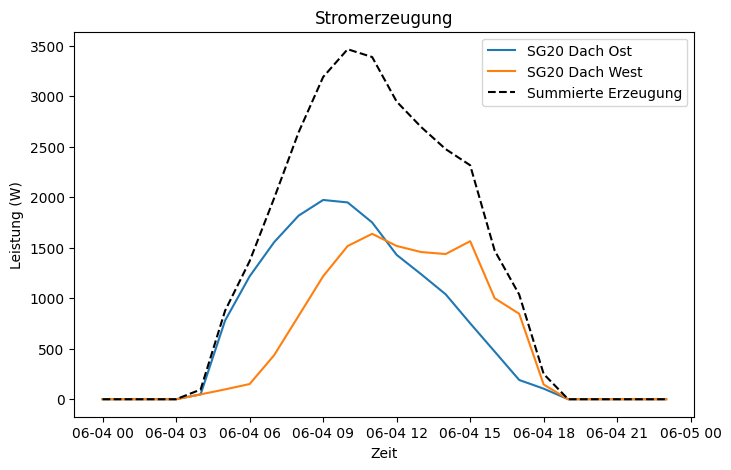

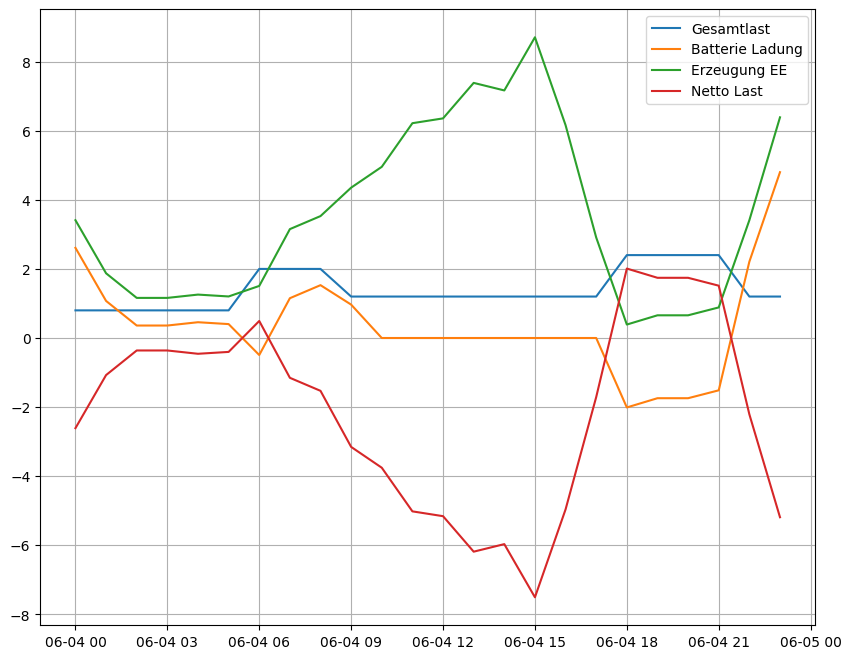

In [1]:
# berücksichtigung der Anzahl in Summe  
import tkinter as tk
from threading import Thread
import constants as c
import constants_wind as cw
import constants_el as cEL
import constants_bat as cb 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

# from functions import berechnung_durchfuehren
import functions 
from plotting import plot_results
from sub_functions import diesel_berechnung, get_data, update_vars, get_load_profile, save_results_to_excel, sum_re, extract_bat_data
from functions_wind import wind_sim
from functions_bat import calculation_bat, load_control
from gui_helpers import create_tabs, create_calculation_button, get_entries #, create_checkbox_frame

# Standardwerte für die Eingabefelder
# DEFAULT_VALUES = {
#     # Algemein 
#     'Breitengrad': c.BREITENGRAD,
#     'Laengengrad': c.LAENGENGRAD,
#     'Hoehe': c.HOEHE,
    
#     # PV 
#     'Anstellwinkel': c.ANSTELLWINKEL,
#     'azimuth': c.AZIMUTH,
#     'startzeit': c.STARTZEIT,  #'2021-06-01 00:00:00',
#     'endzeit': c.ENDZEIT,
#     'schrittweite': c.SCHRITTWEITE,  # Standardmäßig 1 Minute Schrittweite
#     'pdc0': c.PDC0,
#     'gamma_pdc': c.GAMMA_PDC,
#     'a_ref': c.A_REF,
#     'Il_ref': c.IL_REF,
#     'I0_ref': c.I0_REF,
#     'Rs_ref': c.RS_REF,
#     'Rsh_ref': c.RSH_REF,
#     'Adjust': c.ADJUST,
#     'Technology': c.TECHNOLOGY,
#     'pdc0_inv': c.PDC0_INV,
#     'eta_inv_nom': c.ETA_INV_NOM,
#     'eta_inv_ref': c.ETA_INV_REF,

#     # Wind
#     'Anzahl WEA': cw.ANZAHL_WEA, 
#     'Narbenhoehe': cw.NARBENHOEHE, 
#     'v_min': cw.CUT_IN_SPEED, 
#     'v_n': cw.RATED_SPEED, 
#     'v_max': cw.CUT_OUT_SPEED, 
#     'P_n': cw.RATED_POWER,

#     # Batteriespeicher 
#     'Batteriekapazitaet': cb.CAPACITY_BAT,
#     'Ladeeffizienz': cb.CHARGE_EFFICIENCY,
#     'Entladeeffizienz': cb.DISCHARGE_EFFICIENCY,
#     'Max Ladeleistung': cb.MAX_CHARGE_RATE,
#     'Max Entladeleistung': cb.MAX_DISCHARGE_RATE,
#     'Anfangsenergie': cb.INITIAL_ENERGY, 
#     'Min Ladezustand': cb.MIN_BATTERY_LEVEL, 
#     'Max Ladezustand': cb.MAX_BATTERY_LEVEL,


#     # Elektrolyse 
#     'Anzahl EL': cEL.ANZAHL_EL, 
#     'Elektrische Leistung': cEL.LEISTUNG_ELEKTRISCH_EL, 
#     'Wasserverbrauch': cEL.WASSERVERBRUACH_EL

# }

DEFAULT_VALUES = {
    # Algemein
    'Breitengrad': {'value': c.BREITENGRAD, 'unit': '°'},
    'Laengengrad': {'value': c.LAENGENGRAD, 'unit': '°'},
    'Hoehe': {'value': c.HOEHE, 'unit': 'Meter'},
    
    'Anstellwinkel': {'value': c.ANSTELLWINKEL, 'unit': '°'},
    'azimuth': {'value': c.AZIMUTH, 'unit': '°'},
    'startzeit': {'value': c.STARTZEIT, 'unit': 'YYYY-MM-DD HH:MM:SS'},
    'endzeit': {'value': c.ENDZEIT, 'unit': 'YYYY-MM-DD HH:MM:SS'},
    'schrittweite': {'value': c.SCHRITTWEITE, 'unit': 'Stunden'},
    # PV 
    'pdc0': {'value': c.PDC0, 'unit': 'Watt'},
    'gamma_pdc': {'value': c.GAMMA_PDC, 'unit': '%'},
    'a_ref': {'value': c.A_REF, 'unit': ''},
    'Il_ref': {'value': c.IL_REF, 'unit': ''},
    'I0_ref': {'value': c.I0_REF, 'unit': ''},
    'Rs_ref': {'value': c.RS_REF, 'unit': ''},
    'Rsh_ref': {'value': c.RSH_REF, 'unit': ''},
    'Adjust': {'value': c.ADJUST, 'unit': ''},
    'Technology': {'value': c.TECHNOLOGY, 'unit': ''},
    'pdc0_inv': {'value': c.PDC0_INV, 'unit': 'W'},
    'eta_inv_nom': {'value': c.ETA_INV_NOM, 'unit': '%'},
    'eta_inv_ref': {'value': c.ETA_INV_REF, 'unit': '%'},

    # Wind
    'Anzahl WEA': {'value': cw.ANZAHL_WEA, 'unit': ''}, 
    'P_n': {'value': cw.RATED_POWER, 'unit': 'W'},
    'Narbenhoehe': {'value': cw.NARBENHOEHE, 'unit': 'm'}, 
    'v_min': {'value': cw.CUT_IN_SPEED, 'unit': 'm/s'}, 
    'v_n': {'value': cw.RATED_SPEED, 'unit': 'm/s'}, 
    'v_max': {'value': cw.CUT_OUT_SPEED, 'unit': 'm/s'}, 
    
    # Batteriespeicher 
    'Batteriekapazitaet': {'value': cb.CAPACITY_BAT, 'unit': 'kWh'},
    'Ladeeffizienz': {'value': cb.CHARGE_EFFICIENCY, 'unit': '%'},
    'Entladeeffizienz': {'value': cb.DISCHARGE_EFFICIENCY, 'unit': '%'},
    'Max Ladeleistung': {'value': cb.MAX_CHARGE_RATE, 'unit': 'kW'},
    'Max Entladeleistung': {'value': cb.MAX_DISCHARGE_RATE, 'unit': 'kW'},
    'Anfangsenergie': {'value': cb.INITIAL_ENERGY, 'unit': 'kWh (empfohlen: Hälfte der Kapazität)'}, 
    'Min Ladezustand': {'value': cb.MIN_BATTERY_LEVEL, 'unit': '%'}, 
    'Max Ladezustand': {'value': cb.MAX_BATTERY_LEVEL, 'unit': '%'},

    # Elektrolyse 
    'Anzahl EL': {'value': cEL.ANZAHL_EL, 'unit': 'Anzahl'}, 
    'Elektrische Leistung': {'value': cEL.LEISTUNG_ELEKTRISCH_EL, 'unit': 'kW'}, 
    'Wasserverbrauch': {'value': cEL.WASSERVERBRUACH_EL, 'unit': 'l/h'}
}

class PVLeistungsberechnung:
    # zelttypen = ["SG20", "SG30", "SG40", "SG50"]
    anzahl_vars = {}
    belegung_vars = {}
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.entries = []
        
        # Initialize instance variables for anzahl_vars and belegung_vars
        self.anzahl_vars = {}
        self.belegung_vars = {}

        # Create tabs and get checkbox variables
        self.tab_control = create_tabs(self.root, self.entries, DEFAULT_VALUES, self.anzahl_vars, self.belegung_vars)

        create_calculation_button(self.root, self.starte_berechnung)

    def starte_berechnung(self):
        print("Start der Berechnung")
        # Update variables before starting calculation
        # update_vars(self.anzahl_vars, self.belegung_vars)
        thread = Thread(target=self.berechnung_thread)
        thread.start()

    
    def berechnung_thread(self):
        # # Debug output of variables
        # print(f"anzahl_vars: {self.anzahl_vars}")
        # print(f"belegung_vars: {self.belegung_vars}")

        # Prepare a list of selected areas for plotting
        selected_areas = []
        for zelt, belegungen in self.belegung_vars.items():
            if self.anzahl_vars[zelt].get() == 0:
                continue  # Skip this tent type if its count is 0
            for belegung, var in belegungen.items():
                if var.get():  # Ensure that we get the actual value of the BooleanVar
                    selected_areas.append(f"{zelt} {belegung}")

        # get Data 
        standort, wetterdaten, location_data = get_data(self.entries)

        df_load = get_load_profile(self.entries)


        # Perform PV calculation
        erzeugte_energien, stromerzeugungen, berechnungszeiten , df_results = functions.calculation_pv(
            self.entries, self.anzahl_vars, self.belegung_vars, standort, wetterdaten, location_data, df_load)



        # Perform Wind calculation 
        df_wind, wind_energy_output_single, wind_energy_output_total, Anzahl = wind_sim(self.entries, df_results)

        # Zusammenfassen der EE 
        df_results = sum_re(df_results)
        # print(f"df_results: \n{df_results}")

        # params = extract_bat_data(self.entries)
        # battery_energy = params['Anfangsenergie']
        # df_results['Batterie Ladung'] = 0.0
        # df_results['Backup Generator'] = 0.0
        # df_results['Batterie Energie'] = battery_energy
        # print(f"df_results: \n{df_results}")



        # Ladecontroller
        df_results = load_control(self.entries, df_results)
        # print(f"df_results: \n{df_results}")
        save_results_to_excel(df_results, c.EXPORT_FOLDER, "df_results")

        # print(df_results.index)
        # print(df_results.columns)




        # # Erstellen des interaktiven Plotly-Plots
        # fig = go.Figure()
        # for column in df_results.columns:
        #     fig.add_trace(go.Scatter(x=df_results.index, y=df_results[column], mode='lines', name=column))
        # fig.update_layout(
        #     title='Alle Spalten',
        #     xaxis_title='Index',
        #     yaxis_title='Werte',
        #     legend_title='Spalten'
        # )
        # fig.show()







        # Perform Batterie calculation
        df_results = calculation_bat(self.entries, df_results)


        # Ergebnisse verarbeiten und plotten
        if erzeugte_energien is not None and stromerzeugungen is not None:

            summierte_erzeugte_energie = sum(erzeugte_energien)

            dieselmenge, eingesparte_energie = diesel_berechnung(summierte_erzeugte_energie)

            plot_results(self.root, erzeugte_energien, stromerzeugungen, 
                         df_wind, wind_energy_output_single, wind_energy_output_total, Anzahl, 
                         dieselmenge, eingesparte_energie, berechnungszeiten, self.entries, selected_areas, df_results)


if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


In [ ]:
# mehrere Zelte Working  
import tkinter as tk
from threading import Thread
import constants as c
# from functions import berechnung_durchfuehren
import functions
from plotting import plot_results
from sub_functions import diesel_berechnung
from gui_helpers import create_tabs, create_calculation_button, get_entries #, create_checkbox_frame

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'Breitengrad': c.BREITENGRAD,
    'Laengengrad': c.LAENGENGRAD,
    'Hoehe': c.HOEHE,
    'Anstellwinkel': c.ANSTELLWINKEL,
    'azimuth': c.AZIMUTH,
    'startzeit': c.STARTZEIT,  #'2021-06-01 00:00:00',
    'endzeit': c.ENDZEIT,
    'schrittweite': c.SCHRITTWEITE,  # Standardmäßig 1 Minute Schrittweite
    'pdc0': c.PDC0,
    'gamma_pdc': c.GAMMA_PDC,
    'a_ref': c.A_REF,
    'Il_ref': c.IL_REF,
    'I0_ref': c.I0_REF,
    'Rs_ref': c.RS_REF,
    'Rsh_ref': c.RSH_REF,
    'Adjust': c.ADJUST,
    'Technology': c.TECHNOLOGY,
    'pdc0_inv': c.PDC0_INV,
    'eta_inv_nom': c.ETA_INV_NOM,
    'eta_inv_ref': c.ETA_INV_REF
}

class PVLeistungsberechnung:
    # zelttypen = ["SG20", "SG30", "SG40", "SG50"]
    anzahl_vars = {}
    belegung_vars = {}
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.entries = []
        
        # Initialize instance variables for anzahl_vars and belegung_vars
        self.anzahl_vars = {}
        self.belegung_vars = {}

        # Create tabs and get checkbox variables
        self.tab_control = create_tabs(self.root, self.entries, DEFAULT_VALUES, self.anzahl_vars, self.belegung_vars)

        create_calculation_button(self.root, self.starte_berechnung)

    def starte_berechnung(self):
        # Update variables before starting calculation
        self.update_vars()
        thread = Thread(target=self.berechnung_thread)
        thread.start()

    def update_vars(self):
        for zelt, var in self.anzahl_vars.items():
            print(f"Updating {zelt}_ANZAHL to {var.get()}")
        for zelt, belegungen in self.belegung_vars.items():
            for belegung, var in belegungen.items():
                print(f"Updating {zelt}_{belegung} to {var.get()}")
    
    def berechnung_thread(self):
        # Debug output of variables
        print(f"anzahl_vars: {self.anzahl_vars}")
        print(f"belegung_vars: {self.belegung_vars}")

        # Prepare a list of selected areas for plotting
        selected_areas = []
        for zelt, belegungen in self.belegung_vars.items():
            if self.anzahl_vars[zelt].get() == 0:
                continue  # Skip this tent type if its count is 0
            for belegung, var in belegungen.items():
                if var.get():  # Ensure that we get the actual value of the BooleanVar
                    selected_areas.append(f"{zelt} {belegung}")

        # Perform calculation
        erzeugte_energien, stromerzeugungen, berechnungszeiten = functions.calculation_pv(
            self.entries, self.anzahl_vars, self.belegung_vars)
        
        # Ergebnisse verarbeiten und plotten
        if erzeugte_energien is not None and stromerzeugungen is not None:
            summierte_erzeugte_energie = sum(erzeugte_energien)
            dieselmenge, eingesparte_energie = diesel_berechnung(summierte_erzeugte_energie)
            plot_results(self.root, erzeugte_energien, stromerzeugungen, dieselmenge, eingesparte_energie, berechnungszeiten, self.entries, selected_areas)




    # def starte_berechnung(self):
    #     thread = Thread(target=self.berechnung_thread)
    #     thread.start()

    # def berechnung_thread(self):
    #     erzeugte_energien, stromerzeugungen, berechnungszeiten = berechnung_durchfuehren(self.entries, self.anzahl_vars, self.belegung_vars)
    #     if erzeugte_energien is not None and stromerzeugungen is not None:
    #         summierte_erzeugte_energie = sum(erzeugte_energien)
    #         dieselmenge, eingesparte_energie = diesel_berechnung(summierte_erzeugte_energie)
    #         plot_results(self.root, erzeugte_energien, stromerzeugungen, dieselmenge, eingesparte_energie, berechnungszeiten, self.entries)
            

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


In [ ]:
# copilot V2

import tkinter as tk
from tkinter import ttk
import constants as c  # Importieren Sie die constants.py Datei

# Erstellen Sie das Hauptfenster
root = tk.Tk()
root.title("Zeltbelegung")

# Erstellen Sie die Registerkartensteuerung
tab_control = ttk.Notebook(root)
tab4 = ttk.Frame(tab_control)
tab_control.add(tab4, text='Zeltbelegung')
tab_control.pack(expand=1, fill='both')

# Definieren Sie die Zelttypen und Belegungen
zelttypen = ["SG20", "SG30", "SG40", "SG50"]
belegungen = ['Dach Ost', 'Dach West', 'Seite Ost', 'Seite West']

# Variablen zur Speicherung der Werte
anzahl_vars = {}
belegung_vars = {}

# Erstellen Sie für jeden Zelttyp eine Gruppe von Kontrollkästchen und ein Eingabefeld für die Anzahl
for zelt in zelttypen:
    frame = ttk.LabelFrame(tab4, text=zelt)
    frame.pack(fill='x', padx=10, pady=10)
    
    # Korrektur: Der Standardwert wird hier korrekt gesetzt
    anzahl = tk.IntVar(value=getattr(c, f"{zelt}_ANZAHL", 0))
    anzahl_vars[zelt] = anzahl  # Speichern der IntVar für späteren Zugriff
    anzahl_label = ttk.Label(frame, text="Anzahl:")
    anzahl_label.pack(side='left')
    anzahl_entry = ttk.Entry(frame, textvariable=anzahl, width=5)
    anzahl_entry.pack(side='left', padx=10, pady=5)
    
    belegung_vars[zelt] = {}
    # Standardbelegungen aus constants.py laden
    standard_belegungen = getattr(c, f"{zelt}_BELEGUNGEN", {})
    for belegung in belegungen:
        var = tk.BooleanVar(value=standard_belegungen.get(belegung, False))  # Standardwert für Checkboxen
        belegung_vars[zelt][belegung] = var  # Speichern der BooleanVar für späteren Zugriff
        chk = ttk.Checkbutton(frame, text=belegung, variable=var)
        chk.pack(side='left', padx=10, pady=5)

def print_values():
    for zelt in zelttypen:
        anzahl = anzahl_vars[zelt].get()
        print(f"{zelt} Anzahl: {anzahl}")
        for belegung in belegungen:
            wert = belegung_vars[zelt][belegung].get()
            print(f"{zelt} {belegung}: {wert}")

print_button = ttk.Button(root, text="Werte drucken", command=print_values)
print_button.pack(pady=10)

root.mainloop()



In [ ]:
# chat gpt 
import tkinter as tk
from tkinter import ttk

# Funktion zur Erstellung der Zeltbelegungs-Frames
def create_tent_frame(tab, tent_type):
    frame = ttk.Labelframe(tab, text=tent_type)
    frame.pack(fill='x', padx=10, pady=5)

    # Eingabefeld für die Anzahl der Zelte
    lbl_count = ttk.Label(frame, text="Anzahl der Zelte:")
    lbl_count.pack(side='left', padx=5, pady=5)
    entry_count = ttk.Entry(frame, width=5)
    entry_count.pack(side='left', padx=5, pady=5)

    # Checkboxen für Belegungen
    belegungen = ['Dach Ost', 'Dach West', 'Seite Ost', 'Seite West']
    vars = []
    for belegung in belegungen:
        var = tk.BooleanVar()
        vars.append(var)
        checkbox = ttk.Checkbutton(frame, text=belegung, variable=var)
        checkbox.pack(side='left', padx=5, pady=5)

# Hauptfenster erstellen
root = tk.Tk()
root.title("Zeltbelegung")

# Tab-Control erstellen
tab_control = ttk.Notebook(root)

# Tab für Zeltbelegungen erstellen
tab4 = ttk.Frame(tab_control)
tab_control.add(tab4, text='Zeltbelegung')
tab_control.pack(expand=1, fill='both')

# Zelttypen definieren
zelttypen = ["SG 20", "SG 30", "SG 40", "SG 50"]

# Zeltbelegungs-Frames für jeden Zelttyp erstellen
for tent_type in zelttypen:
    create_tent_frame(tab4, tent_type)

# Hauptloop starten
root.mainloop()


In [ ]:
# alt ohne auslagerung 
import tkinter as tk
from tkinter import ttk
from threading import Thread
import constants as c
from functions import calculation_pv
from plotting import plot_results
from sub_functions import diesel_berechnung

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'Breitengrad': c.BREITENGRAD,
    'Laengengrad': c.LAENGENGRAD,
    'Hoehe': c.HOEHE,
    'Anstellwinkel': c.ANSTELLWINKEL,
    'azimuth': c.AZIMUTH,
    'startzeit': '2021-06-01 00:00:00',
    'endzeit': '2021-06-01 23:59:59',
    'schrittweite': '1',  # Standardmäßig 1 Minute Schrittweite
    'pdc0': c.PDC0,
    'gamma_pdc': c.GAMMA_PDC,
    'a_ref': c.A_REF,
    'Il_ref': c.IL_REF,
    'I0_ref': c.I0_REF,
    'Rs_ref': c.RS_REF,
    'Rsh_ref': c.RSH_REF,
    'Adjust': c.ADJUST,
    'Technology': c.TECHNOLOGY,
    'pdc0_inv': c.PDC0_INV,
    'eta_inv_nom': c.ETA_INV_NOM,
    'eta_inv_ref': c.ETA_INV_REF
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.tabs = []
        self.entries = []

        self.create_tabs()
        self.create_calculation_button()

    def create_tabs(self):
        tab_control = ttk.Notebook(self.root)
        
        # Tab für allgemeine Einstellungen
        tab1 = ttk.Frame(tab_control)
        tab_control.add(tab1, text='Allgemein')
        self.create_input_frame(tab1, ['Breitengrad', 'Laengengrad', 'Hoehe', 'Anstellwinkel', 'azimuth', 'startzeit', 'endzeit', 'schrittweite'])
        self.tabs.append(tab1)

        # Tab für Modulparameter
        tab2 = ttk.Frame(tab_control)
        tab_control.add(tab2, text='Modulparameter')
        self.create_input_frame(tab2, ['pdc0', 'gamma_pdc', 'a_ref', 'Il_ref', 'I0_ref', 'Rs_ref', 'Rsh_ref', 'Adjust', 'Technology'])
        self.tabs.append(tab2)

        # Tab für Wechselrichterparameter
        tab3 = ttk.Frame(tab_control)
        tab_control.add(tab3, text='Wechselrichterparameter')
        self.create_input_frame(tab3, ['pdc0_inv', 'eta_inv_nom', 'eta_inv_ref'])
        self.tabs.append(tab3)

        # Tab für Zeltbelegung
        tab4 = ttk.Frame(tab_control)
        tab_control.add(tab4, text='Zeltbelegung')
        self.create_combobox_frame(tab4, ["SG 30", "SG 50", "SG 300", "SG 500"])
        self.create_checkbox_frame(tab4, ['Dach Ost', 'Dach West', 'Seite Ost', 'Seite West'])
        self.tabs.append(tab4)

        tab_control.pack(expand=1, fill='both')

    def create_input_frame(self, frame, keys):
        frame = tk.Frame(frame, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        entries = {}
        row = 0
        for key in keys:
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, DEFAULT_VALUES[key])
            entries[key] = entry
            row += 1

        self.entries.append(entries)

    def create_checkbox_frame(self, parent, options):
        frame = ttk.Frame(parent, padding= 30)
        frame.pack(padx=50, pady=10, fill='both', expand=True)
        
        self.checkbox_vars = []
        for option in options:
            var = tk.BooleanVar()
            checkbox = ttk.Checkbutton(frame, text=option, variable=var)
            checkbox.pack(anchor='w', pady= 5)
            self.checkbox_vars.append(var)

    def create_combobox_frame(self, parent, values):
        frame = ttk.Frame(parent, padding=10)
        frame.pack(padx=10, pady=10, fill='both', expand=True)

        label = ttk.Label(frame, text="Select an SG value:")
        label.pack(pady=5)

        combo = ttk.Combobox(frame, values=values)
        combo.pack(pady=5)
        combo.bind("<<ComboboxSelected>>", self.on_select)

    def on_select(self, event):
        selected_value = event.widget.get()
        print(f"Selected: {selected_value}")

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_thread)
        thread.start()

    def berechnung_thread(self):
        # stromerzeugung = float(stromerzeugung)
        erzeugte_energie, stromerzeugung, berechnungszeit = calculation_pv(self.entries)
        if erzeugte_energie is not None and stromerzeugung is not None:
            dieselmenge, eingesparte_energie = diesel_berechnung(erzeugte_energie)
            plot_results(self.root, erzeugte_energie, stromerzeugung, dieselmenge, eingesparte_energie, berechnungszeit, self.entries)
            

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


In [ ]:
# Combobox 
import tkinter as tk
from tkinter import ttk

def on_select(event):
    selected_value = combo.get()
    print(f"Selected: {selected_value}")

# Hauptfenster erstellen
root = tk.Tk()
root.title("Tkinter Dropdown Example")

# Label für das Dropdown-Menü
label = tk.Label(root, text="Select an SG value:")
label.pack(pady=10)

# Dropdown-Menü (ComboBox) erstellen
values = ["SG 30", "SG 50", "SG 300", "SG 500"]
combo = ttk.Combobox(root, values=values)
combo.pack(pady=10)

# Event-Handler für Auswahl hinzufügen
combo.bind("<<ComboboxSelected>>", on_select)

# Hauptschleife starten
root.mainloop()


In [ ]:
# Eingabemaske für Zelte 

import tkinter as tk
from tkinter import ttk, messagebox

class ZeltSimulationApp(tk.Tk):
    def __init__(self):
        super().__init__()

        self.title("Zelt Simulation")

        self.create_widgets()

    def create_widgets(self):
        # Zelttypen und Anzahl
        self.zelttypen_label = tk.Label(self, text="Zelttypen:")
        self.zelttypen_label.grid(row=0, column=0, padx=10, pady=5)

        self.zelttypen = ["SG 30", "SG 50", "SG 300", "SG 500"]
        self.zelttypen_var = tk.StringVar(value=self.zelttypen[0])
        self.zelttypen_dropdown = ttk.Combobox(self, textvariable=self.zelttypen_var, values=self.zelttypen)
        self.zelttypen_dropdown.grid(row=0, column=1, padx=10, pady=5)

        self.anzahl_label = tk.Label(self, text="Anzahl:")
        self.anzahl_label.grid(row=0, column=2, padx=10, pady=5)

        self.anzahl_var = tk.IntVar(value=1)
        self.anzahl_spinbox = tk.Spinbox(self, from_=1, to=100, textvariable=self.anzahl_var)
        self.anzahl_spinbox.grid(row=0, column=3, padx=10, pady=5)

        # Flächen der Zelttypen
        self.flaechen_label = tk.Label(self, text="Flächen:")
        self.flaechen_label.grid(row=1, column=0, padx=10, pady=5)

        self.flaechen_vars = {
            "Dach Ost": tk.BooleanVar(),
            "Dach West": tk.BooleanVar(),
            "Seite Ost": tk.BooleanVar(),
            "Seite West": tk.BooleanVar()
        }

        for i, (flaeche, var) in enumerate(self.flaechen_vars.items()):
            cb = tk.Checkbutton(self, text=flaeche, variable=var)
            cb.grid(row=1, column=i+1, padx=10, pady=5)

        # Buttons
        self.add_button = tk.Button(self, text="Hinzufügen", command=self.add_zelt)
        self.add_button.grid(row=2, column=0, columnspan=4, pady=10)

        self.analyze_button = tk.Button(self, text="Analysieren", command=self.analyze)
        self.analyze_button.grid(row=3, column=0, columnspan=4, pady=10)

        # Anzeige der Ergebnisse
        self.results_label = tk.Label(self, text="Ergebnisse:")
        self.results_label.grid(row=4, column=0, padx=10, pady=5)

        self.results_text = tk.Text(self, height=10, width=100)
        self.results_text.grid(row=5, column=0, columnspan=4, padx=10, pady=5)

        # Liste der Zelte für die Analyse
        self.zelte_list = []

    def add_zelt(self):
        zelt_typ = self.zelttypen_var.get()
        anzahl = self.anzahl_var.get()
        flaechen = [flaeche for flaeche, var in self.flaechen_vars.items() if var.get()]

        if not flaechen:
            messagebox.showwarning("Warnung", "Bitte wählen Sie mindestens eine Fläche aus.")
            return

        self.zelte_list.append((zelt_typ, anzahl, flaechen))
        self.display_zelte()

    def display_zelte(self):
        self.results_text.delete("1.0", tk.END)
        for zelt in self.zelte_list:
            zelt_info = f"Typ: {zelt[0]}, Anzahl: {zelt[1]}, Flächen: {', '.join(zelt[2])}\n"
            self.results_text.insert(tk.END, zelt_info)

    def analyze(self):
        if not self.zelte_list:
            messagebox.showwarning("Warnung", "Bitte fügen Sie zuerst Zelte hinzu.")
            return

        # Simulationslogik hier hinzufügen
        # Für dieses Beispiel wird eine einfache Ausgabe gemacht
        self.results_text.insert(tk.END, "\nAnalyse der Zeltkonstellationen:\n")
        for zelt in self.zelte_list:
            self.results_text.insert(tk.END, f"Analysiere: Typ: {zelt[0]}, Anzahl: {zelt[1]}, Flächen: {', '.join(zelt[2])}\n")

if __name__ == "__main__":
    app = ZeltSimulationApp()
    app.mainloop()


In [ ]:
# test mit externer py Datei 

import constants as c 
# import functions as fnc
from functions import *

placeholder()

print(c.BREITENGRAD)
print(c.LAENGENGRAD)
print(c.ZEITZONE)

# PV-Moduldatenbank